In [ ]:
pip install tensorflow-text tf-models-official transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import datetime
import os
import torch
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras import regularizers
import tensorflow_hub as hub
from keras import layers, Model
import nltk
from transformers import AutoTokenizer
from nltk.tokenize import word_tokenize
import re
nltk.download('punkt',quiet=True)
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet',quiet=True)
nltk.download('omw-1.4',quiet=True)
lemmatizer = WordNetLemmatizer()
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from keras.callbacks import EarlyStopping, TensorBoard
import tensorflow_text as text
tf.get_logger().setLevel('ERROR')
from official.nlp import optimization  

import matplotlib.pyplot as plt
import shutil

In [ ]:
df = pd.read_csv('Mental-Health-Twitter.csv')
df['text']=df.post_text
df.drop(columns={'post_text','Unnamed: 0','post_id','post_created','user_id','followers','friends','favourites','statuses','retweets'},inplace=True)
df.head()

,label,text
0,1,It's just over 2 years since I was diagnosed w...
1,1,"It's Sunday, I need a break, so I'm planning t..."
2,1,Awake but tired. I need to sleep but my brain ...
3,1,RT @SewHQ: #Retro bears make perfect gifts and...
4,1,It’s hard to say whether packing lists are mak...


In [ ]:
def preprocess(df_mentalhealth):
    df_mentalhealth['clean_message']=df_mentalhealth.text.apply(lambda x: x.lower())
    #Using regular expressions to remove any URLs

    def remove_urls(text):
        url_pattern = re.compile(r'https?://\S+|www\.\S+')
        return url_pattern.sub(r'', text)

    df_mentalhealth.clean_message = df_mentalhealth.clean_message.apply(lambda text: remove_urls(text))

    def remove_junk(text):
      #remove special characters
      special_pattern=re.compile(r'[^a-zA-Z0-9\s]')
      text = special_pattern.sub(r'', text)

      username_pattern=re.compile(r'@\S+')
      text = username_pattern.sub(r'', text)

      hashtag_pattern=re.compile(r'#\S+')
      text = hashtag_pattern.sub(r'', text)
      
      return text

    df_mentalhealth.clean_message = df_mentalhealth.clean_message.apply(lambda text: remove_junk(text))


    def remove_html(text):
        html_pattern = re.compile('<.*?>')
        return html_pattern.sub(r'', text)
    df_mentalhealth.clean_message = df_mentalhealth.clean_message.apply(lambda text: remove_html(text))

    def remove_stopwords(text):
        stopwords=['diagnosed','diagnose','depression','suicidal','suicide','kill myself','anxiety','depressed','mental illness','die']
        removed_stop= ' '.join([word for word in text.split() if word.lower() not in stopwords])
        return removed_stop
    
    df_mentalhealth.clean_message = df_mentalhealth.clean_message.apply(lambda text: remove_stopwords(text))


    df_mentalhealth['message_tokenized'] = df_mentalhealth.apply(lambda x: nltk.word_tokenize(x['clean_message']), axis=1)

    def lemmatize(tokens):
        lemmatized = [lemmatizer.lemmatize(token) for token in tokens]
        return lemmatized
    

    df_mentalhealth['text']=df_mentalhealth.message_tokenized.apply(lambda x: lemmatize(x))
  
    df_mentalhealth.text=df_mentalhealth.text.apply(lambda x: ' '.join(x))
    df_mentalhealth = df_mentalhealth[df_mentalhealth['text'].apply(lambda x: len(x.split()) > 5)]
    df_mentalhealth=df_mentalhealth[['text','label']]

    return df_mentalhealth


df=preprocess(df)

In [ ]:
for i in range(10):
  print(df.text[i])

it just over 2 year since i wa with and today im taking a moment to reflect on how far ive come since
it sunday i need a break so im planning to spend a little time a possible on the a14
awake but tired i need to sleep but my brain ha other idea
rt sewhq retro bear make perfect gift and are great for beginner too get stitching with october sew on sale now yay
it hard to say whether packing list are making life easier or just reinforcing how much still need doing movinghouse
making packing list is my new hobby movinghouse
at what point doe keeping stuff for nostalgic reason cross the line into plain old hoarding movinghouse
currently in the findingboxesofrandomshit packing phase i think im a closet hoarder
cant be bothered to cook take away on the way lazy
rt itventsnews itv release promo video for the final series of downton abbey


In [ ]:
df_non=df[df.label == 0].reset_index()
for i in range(20):
  print(df_non.text[i])

my enemy invisible i dont know how to fight
im gon na burn my house down into an ugly brack
rt leagueoflegends pbe preview warring kingdom garen splash art
rt leagueoflegends pbe preview heartseeker quinn splash art
i lvoe them so much im gon na cry
rt blackchalkmzine katherine mcnamara a touch of destiny
adclaidekanes this 2 scream hurt me even tho that upbeat music made everything seem fun
adclaidekanes followed closely by the studying scene where she show him shes using his system ok dont me at all for any reaos n
i dont go here anymore but stile and malias best scene is still the basement scene in s4 thank u goodnight dont me at all for any reason
beliamysciarkes i dont knwo the editing term for it but the space part im dead
adclaidekanes also ive literally never wanted to physically fight someone a much a i want to fight her and that almost happened tonight
just popping in to say that i got to hurl a cup of water at my step sister and not get in trouble for it and thats awesome
i 

In [ ]:

bert_model_name = 'bert_en_uncased_L-12_H-768_A-12'

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [ ]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df['label'])


print(f"Train set shape: {train_df.shape}")
print(f"Validation set shape: {val_df.shape}")
print(f"Test set shape: {test_df.shape}")

Train set shape: (10055, 2)
Validation set shape: (2514, 2)
Test set shape: (3143, 2)


In [ ]:
def convert_to_tensor(df):
    
    AUTOTUNE = tf.data.AUTOTUNE
    batch_size = 32
    seed = 42
    # Convert the text and label columns to NumPy arrays
    texts = df['text'].values
    labels = df['label'].values

    # Create a TensorFlow dataset from the NumPy arrays
    dataset = tf.data.Dataset.from_tensor_slices((texts, labels))

    # Define a batch size
    batch_size = 32

    # Shuffle and batch the dataset
    dataset = dataset.shuffle(buffer_size=len(df)).batch(batch_size)

    # Prefetch the dataset for better performance
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

    return dataset


train_df=convert_to_tensor(train_df)
test_df=convert_to_tensor(test_df)
val_df=convert_to_tensor(val_df)

In [ ]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)


In [ ]:
text_test = ['I am so sad']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_type_ids', 'input_mask', 'input_word_ids']
Shape      : (1, 128)
Word Ids   : [ 101 1045 2572 2061 6517  102    0    0    0    0    0    0]
Input Mask : [1 1 1 1 1 1 0 0 0 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [ ]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0,]}')
print(len(bert_results["sequence_output"][0,]))

Loaded BERT: https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Pooled Outputs Shape:(1, 768)
Pooled Outputs Values:[-0.88111097 -0.35659465 -0.540821    0.74493474  0.2452222  -0.11287791
  0.78960145  0.21389958 -0.58410925 -0.99996257 -0.16938911  0.9297684 ]
Sequence Outputs Shape:(1, 128, 768)
Sequence Outputs Values:[[-0.02679018  0.4842894  -0.15463954 ...  0.10743914  0.3552013
   0.2223004 ]
 [-0.39250124  0.53447205 -0.32618445 ...  0.22870569  0.9778888
   0.19354719]
 [-0.47899675  0.50497335 -0.16819412 ...  0.15936847  0.36506164
   0.2632398 ]
 ...
 [-0.14800009  0.35884216  0.43554658 ...  0.3858491  -0.12212268
   0.09391703]
 [-0.01930816  0.35823488  0.5149218  ...  0.47387972  0.03781739
   0.10367188]
 [-0.0654356   0.29186344  0.48361838 ...  0.43498504 -0.04278959
   0.07457445]]
128


In [ ]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [ ]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.6742529]], shape=(1, 1), dtype=float32)


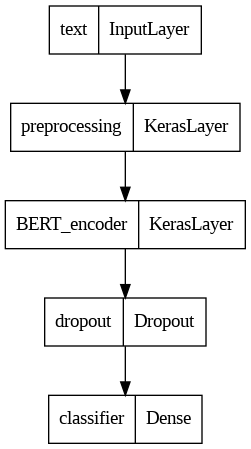

In [ ]:
tf.keras.utils.plot_model(classifier_model)

In [ ]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
metrics = tf.metrics.BinaryAccuracy()

In [ ]:
epochs = 10
steps_per_epoch = tf.data.experimental.cardinality(train_df).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

early_stop = EarlyStopping(monitor='val_loss', patience=3)

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)



In [ ]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_df,
                               validation_data=val_df,
                               epochs=epochs,
                               callbacks=[tensorboard_callback, early_stop])

Training model with https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Epoch 1/10


In [ ]:
loss, accuracy = classifier_model.evaluate(test_df)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


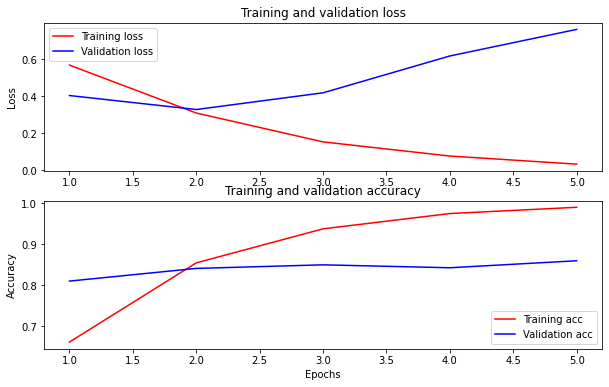

In [ ]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [ ]:
def preprocess_single_text(text):
    text=text.lower()

    def remove_urls(text):
        url_pattern = re.compile(r'https?://\S+|www\.\S+')
        return url_pattern.sub(r'', text)

    text=remove_urls(text)

    def remove_junk(text):
      special_pattern=re.compile(r'[^a-zA-Z0-9\s]')
      text = special_pattern.sub(r'', text)

      username_pattern=re.compile(r'@\S+')
      text = username_pattern.sub(r'', text)

      hashtag_pattern=re.compile(r'#\S+')
      text = hashtag_pattern.sub(r'', text)
      
      return text

    text=remove_junk(text)


    def remove_html(text):
        html_pattern = re.compile('<.*?>')
        return html_pattern.sub(r'', text)
    text= remove_html(text)

    def remove_stopwords(text):
        stopwords=['diagnosed','diagnose','depression','suicidal','suicide','kill myself','anxiety','depressed','mental illness','die']
        removed_stop= ' '.join([word for word in text.split() if word.lower() not in stopwords])
        return removed_stop
    
    text= remove_stopwords(text)


    text =  nltk.word_tokenize(text)

    def lemmatize(tokens):
        lemmatized = [lemmatizer.lemmatize(token) for token in tokens]
        return lemmatized
    

    text= lemmatize(text)
  
    text= ' '.join(text)

    return text




text_test =[
    'I am so sad',  
    'They were so mean to me. They told be I dont have any friends',
    'I want to kill myself',
    'I had so much fun on vacation',
    'Yeah i went to the store and got some bread'
]

for text in text_test:
  text=preprocess_single_text(text)
  
  print(classifier_model.predict([text]))


1/1 [==============================] - 2s 2s/step
[[5.7144957]]
1/1 [==============================] - 0s 57ms/step
[[7.1799674]]
1/1 [==============================] - 0s 51ms/step
[[-1.1311817]]
1/1 [==============================] - 0s 48ms/step
[[7.1446724]]
1/1 [==============================] - 0s 63ms/step
[[7.4295278]]


In [ ]:
dataset_name = 'mental_health'
saved_model_path = './{}_bert'.format(dataset_name.replace('/', '_'))

classifier_model.save(saved_model_path, include_optimizer=False)

In [ ]:

reloaded_model = tf.saved_model.load(saved_model_path)

def print_my_examples(inputs, results):
  result_for_printing = \
    [f'input: {inputs[i]:<30} : score: {results[i][0]:.6f}'
                         for i in range(len(inputs))]
  print(*result_for_printing, sep='\n')
  print()


examples = [
    'I am so sad',  
    'They were so mean to me. They told be I dont have any friends',
    'I want to kill myself',
    'I had so much fun on vacation',
    'Yeah i went to the store and got some bread'
]

reloaded_results = tf.sigmoid(reloaded_model(tf.constant(examples)))
original_results = tf.sigmoid(classifier_model(tf.constant(examples)))

print('Results from the saved model:')
print_my_examples(examples, reloaded_results)
print('Results from the model in memory:')
print_my_examples(examples, original_results)

Results from the saved model:
input: I am so sad                    : score: 0.669241
input: They were so mean to me. They told be I dont have any friends : score: 0.843546
input: I want to kill myself          : score: 0.689672
input: I had so much fun on vacation  : score: 0.978781
input: Yeah i went to the store and got some bread : score: 0.962673

Results from the model in memory:
input: I am so sad                    : score: 0.669241
input: They were so mean to me. They told be I dont have any friends : score: 0.843546
input: I want to kill myself          : score: 0.689672
input: I had so much fun on vacation  : score: 0.978781
input: Yeah i went to the store and got some bread : score: 0.962673

